# Coursera Capstone Final Project
## Raymond Mah

Project requirements: Use location data to explore a geographical location.  Students will have the opportunity to be as creative as they want and come up with an idea to leverage the Foursquare location data to explore or compare neighborhoods or cities of their choice or to come up with a problem that you can use the Foursquare location data to solve. 

## Coffe Shop Saturation Analysis for the City of Calgary
Scenario selected:  A large Coffee Shop franchise wish to expand into the city of Calgary, AB and requires a data scientist to analyze the most ideal areas in the city for establishing their business. 

## Import all the required libraries for analysis

In [1]:
# import the library we use to open URLs
import urllib.request
# import the BeautifulSoup library so we can parse HTML and XML documents
from bs4 import BeautifulSoup

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

!pip install geopy
from geopy.exc import GeocoderTimedOut 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!pip install geocoder
import geocoder

!pip install pgeocode
import pgeocode # import pgeocode

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import datasets

!pip install folium
import folium # map rendering library

! pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns


print('Libraries imported.')

Libraries imported.


## Build a dataframe with the downloaded 2019 Census data from the City of Calgary

In [2]:
df = pd.read_csv('Calgary_Census_by_Community_2019.csv')
df.head()

CLASS  CLASS_CODE COMM_CODE           NAME     SECTOR         SRG  \
0  Residential           1       LEG         LEGACY      SOUTH  DEVELOPING   
1  Residential           1       HPK  HIGHLAND PARK     CENTRE   BUILT-OUT   
2  Residential           1       CNS    CORNERSTONE  NORTHEAST  DEVELOPING   
3  Residential           1       MON     MONTGOMERY  NORTHWEST   BUILT-OUT   
4  Residential           1       TEM         TEMPLE  NORTHEAST   BUILT-OUT   

  COMM_STRUCTURE  CNSS_YR FOIP_IND  RES_CNT  ...  OTHER_5_14  OTHER_15_19  \
0   BUILDING OUT     2019      NaN     6420  ...           0            0   
1          1950s     2019      NaN     3838  ...           0            0   
2          2000s     2019      NaN     2648  ...           0            0   
3          1950s     2019      NaN     4515  ...           0            0   
4    1960s/1970s     2019      NaN    10977  ...           0            0   

   OTHER_20_24  OTHER_25_34  OTHER_35_44  OTHER_45_54  OTHER_55_64  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   OTHER_65_74  OTHER_75                                       multipolygon  
0            0         0  MULTIPOLYGON (((-114.021996041091 50.863078904...  
1            0         0  MULTIPOLYGON (((-114.0691626854784 51.09565033...  
2            0         0  MULTIPOLYGON (((-113.91839732026011 51.1760690...  
3            0         0  MULTIPOLYGON (((-114.16457918083577 51.0814533...  
4            0         0  MULTIPOLYGON (((-113.93512706147847 51.0960756...  

[5 rows x 142 columns]

## Data Cleaning

In [4]:
# Get names of indexes for which column CLASS has value "Residual Sub Area"
indexNA = df[ df['CLASS'] == "Residual Sub Area" ].index
# Delete these row indexes from dataFrame
df.drop(indexNA , inplace=True)
df.head()

CLASS  CLASS_CODE COMM_CODE           NAME     SECTOR         SRG  \
0  Residential           1       LEG         LEGACY      SOUTH  DEVELOPING   
1  Residential           1       HPK  HIGHLAND PARK     CENTRE   BUILT-OUT   
2  Residential           1       CNS    CORNERSTONE  NORTHEAST  DEVELOPING   
3  Residential           1       MON     MONTGOMERY  NORTHWEST   BUILT-OUT   
4  Residential           1       TEM         TEMPLE  NORTHEAST   BUILT-OUT   

  COMM_STRUCTURE  CNSS_YR FOIP_IND  RES_CNT  ...  OTHER_5_14  OTHER_15_19  \
0   BUILDING OUT     2019      NaN     6420  ...           0            0   
1          1950s     2019      NaN     3838  ...           0            0   
2          2000s     2019      NaN     2648  ...           0            0   
3          1950s     2019      NaN     4515  ...           0            0   
4    1960s/1970s     2019      NaN    10977  ...           0            0   

   OTHER_20_24  OTHER_25_34  OTHER_35_44  OTHER_45_54  OTHER_55_64  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   OTHER_65_74  OTHER_75                                       multipolygon  
0            0         0  MULTIPOLYGON (((-114.021996041091 50.863078904...  
1            0         0  MULTIPOLYGON (((-114.0691626854784 51.09565033...  
2            0         0  MULTIPOLYGON (((-113.91839732026011 51.1760690...  
3            0         0  MULTIPOLYGON (((-114.16457918083577 51.0814533...  
4            0         0  MULTIPOLYGON (((-113.93512706147847 51.0960756...  

[5 rows x 142 columns]

In [5]:
#Please note these neighborhoods may actually be occupied with residents 
# but the 2019 Calgary census was not able to collect the data for them
# Identify neighborhoods that has a 0 RES_CNT
indexNA1 = df[ df['RES_CNT'] == 0 ].index
# Delete these row indexes from dataFrame
df.drop(indexNA1 , inplace=True)
df.head()

CLASS  CLASS_CODE COMM_CODE           NAME     SECTOR         SRG  \
0  Residential           1       LEG         LEGACY      SOUTH  DEVELOPING   
1  Residential           1       HPK  HIGHLAND PARK     CENTRE   BUILT-OUT   
2  Residential           1       CNS    CORNERSTONE  NORTHEAST  DEVELOPING   
3  Residential           1       MON     MONTGOMERY  NORTHWEST   BUILT-OUT   
4  Residential           1       TEM         TEMPLE  NORTHEAST   BUILT-OUT   

  COMM_STRUCTURE  CNSS_YR FOIP_IND  RES_CNT  ...  OTHER_5_14  OTHER_15_19  \
0   BUILDING OUT     2019      NaN     6420  ...           0            0   
1          1950s     2019      NaN     3838  ...           0            0   
2          2000s     2019      NaN     2648  ...           0            0   
3          1950s     2019      NaN     4515  ...           0            0   
4    1960s/1970s     2019      NaN    10977  ...           0            0   

   OTHER_20_24  OTHER_25_34  OTHER_35_44  OTHER_45_54  OTHER_55_64  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   OTHER_65_74  OTHER_75                                       multipolygon  
0            0         0  MULTIPOLYGON (((-114.021996041091 50.863078904...  
1            0         0  MULTIPOLYGON (((-114.0691626854784 51.09565033...  
2            0         0  MULTIPOLYGON (((-113.91839732026011 51.1760690...  
3            0         0  MULTIPOLYGON (((-114.16457918083577 51.0814533...  
4            0         0  MULTIPOLYGON (((-113.93512706147847 51.0960756...  

[5 rows x 142 columns]

In [6]:
df.shape

(211, 142)

In [7]:
#Set a new dataframe with just the data needed
#Statistic Canada reports that coffee consumption peaks at the age 31 to 50, as such only the residents that covers that age range is counted
df1 = pd.DataFrame([df.CLASS,df.NAME,df.SECTOR,df.RES_CNT,df.MALE_CNT,df.FEMALE_CNT,df.MF_25_34,df.MF_35_44,df.MF_45_54,df.OTHER_25_34,df.OTHER_35_44,df.OTHER_45_54]).transpose()
df1.head()

CLASS           NAME     SECTOR RES_CNT MALE_CNT FEMALE_CNT MF_25_34  \
0  Residential         LEGACY      SOUTH    6420     3125       3283     1518   
1  Residential  HIGHLAND PARK     CENTRE    3838     1986       1846      777   
2  Residential    CORNERSTONE  NORTHEAST    2648     1409       1225      607   
3  Residential     MONTGOMERY  NORTHWEST    4515     2216       2291     1003   
4  Residential         TEMPLE  NORTHEAST   10977     5597       5357     1616   

  MF_35_44 MF_45_54 OTHER_25_34 OTHER_35_44 OTHER_45_54  
0     1204      724           0           0           0  
1      798      485           0           0           0  
2      593      261           0           0           0  
3      786      530           0           0           0  
4     1727     1303           0           0           0

In [8]:
#NAME = Full name of the Community District as approved by City Council
#RES_CNT = Number of residents
df1['Number of Residents Age 25 to 54'] = df['MF_25_34'] + df['MF_35_44'] + df['MF_45_54'] + df['OTHER_25_34'] + df['OTHER_35_44'] + df['OTHER_45_54']
df1['NAME'].replace('DOUGLASDALE/GLEN','DOUGLASDALE')
yyc2019 = df1.drop(['MALE_CNT','FEMALE_CNT','MF_25_34','MF_35_44','MF_45_54','OTHER_25_34','OTHER_35_44','OTHER_45_54'], axis=1)

yyc2019.head()

CLASS           NAME     SECTOR RES_CNT  \
0  Residential         LEGACY      SOUTH    6420   
1  Residential  HIGHLAND PARK     CENTRE    3838   
2  Residential    CORNERSTONE  NORTHEAST    2648   
3  Residential     MONTGOMERY  NORTHWEST    4515   
4  Residential         TEMPLE  NORTHEAST   10977   

   Number of Residents Age 25 to 54  
0                              3446  
1                              2060  
2                              1461  
3                              2319  
4                              4646

In [9]:
yyc2019.shape

(211, 5)

## Retrieve the Latitude and Longitude for each neighborhood

In [10]:
#Create a temporary dataframe to format the neighborhood address properly to use Geocoder
a = []
a = yyc2019['NAME']
temp1 = pd.DataFrame(a,columns=['NAME'])

temp1['City'] = 'Calgary'
temp1['Province'] = 'AB'
temp1['address'] = temp1[temp1.columns[0:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
temp1

NAME     City Province                     address
0             LEGACY  Calgary       AB           LEGACY,Calgary,AB
1      HIGHLAND PARK  Calgary       AB    HIGHLAND PARK,Calgary,AB
2        CORNERSTONE  Calgary       AB      CORNERSTONE,Calgary,AB
3         MONTGOMERY  Calgary       AB       MONTGOMERY,Calgary,AB
4             TEMPLE  Calgary       AB           TEMPLE,Calgary,AB
..               ...      ...      ...                         ...
299        EVERGREEN  Calgary       AB        EVERGREEN,Calgary,AB
300  SPRINGBANK HILL  Calgary       AB  SPRINGBANK HILL,Calgary,AB
302    HIDDEN VALLEY  Calgary       AB    HIDDEN VALLEY,Calgary,AB
303        RIVERBEND  Calgary       AB        RIVERBEND,Calgary,AB
304      RIDEAU PARK  Calgary       AB      RIDEAU PARK,Calgary,AB

[211 rows x 4 columns]

In [11]:
# declare an empty list to store latitude and longitude of values of city column 
lat = [] 
long = [] 
   
# function to find the coordinate of a given city  
def findGeocode(city): 
       
    # try and catch is used to overcome the exception thrown by geolocator using geocodertimedout   
    try: 
          
        # Specify the user_agent as your app name it should not be none 
        geolocator = Nominatim(user_agent="ny_explorer") 
          
        return geolocator.geocode(city) 
      
    except GeocoderTimedOut: 
          
        return findGeocode(city)     

In [12]:
# each value from address column will be fetched and sent to function find_geocode    
for i in (temp1['address']): 
      
    if findGeocode(i) != None: 
           
        loc = findGeocode(i) 
          
        # coordinates returned from function is stored into two separate list 
        lat.append(loc.latitude) 
        long.append(loc.longitude) 
       
    #if coordinate for a address not found, insert "NaN" indicating missing value  
    else: 
        lat.append(np.nan) 
        long.append(np.nan)

In [13]:
yyc2019['Latitude']=lat
yyc2019['Longitude']=long
yyc2019.head()

CLASS           NAME     SECTOR RES_CNT  \
0  Residential         LEGACY      SOUTH    6420   
1  Residential  HIGHLAND PARK     CENTRE    3838   
2  Residential    CORNERSTONE  NORTHEAST    2648   
3  Residential     MONTGOMERY  NORTHWEST    4515   
4  Residential         TEMPLE  NORTHEAST   10977   

   Number of Residents Age 25 to 54   Latitude   Longitude  
0                              3446  50.856893 -114.002560  
1                              2060  51.085355 -114.065809  
2                              1461  51.160280 -113.939608  
3                              2319  51.074802 -114.162474  
4                              4646  51.088424 -113.947877

In [14]:
#Only process the cells that have an assigned Latitude and Longitude. Ignore cells with a 'nan' value
yyc2019.dropna(subset = ["Latitude"], inplace=True)

In [15]:
#Output the dataframe in excel to inspect the data
yyc2019.to_excel("yyc2019.xlsx")

## Segmenting and Clustering Neighborhoods in Calgary, AB

In [16]:
print('The dataframe has {} neighborhoods.'.format(yyc2019.shape[0]))

The dataframe has 210 neighborhoods.


## Use geopy library to get the latitude and longitude values of Calgary, AB

In [17]:
ad = 'Calgary, AB'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(ad)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Calgary, AB are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Calgary, AB are 51.0534234, -114.0625892.


## Create a map of Calgary with neighborhoods superimposed on top

In [18]:
# create map of Calgary using latitude and longitude values
map_calgary = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(yyc2019['Latitude'], yyc2019['Longitude'], yyc2019['SECTOR'], yyc2019['NAME']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_calgary)  
    
map_calgary

## Define Foursquare Credentials and Version

In [19]:
CLIENT_ID = 'JHBDUWB22S2BS3SLELEBZTCQXGN2D0ELLXNE4TOZEY2VCCIO' # your Foursquare ID
CLIENT_SECRET = 'O113MIHBXJWQB2KC1MDXH3FPSX5IZZPNHBVQUQL3WG43ZP12' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JHBDUWB22S2BS3SLELEBZTCQXGN2D0ELLXNE4TOZEY2VCCIO
CLIENT_SECRET:O113MIHBXJWQB2KC1MDXH3FPSX5IZZPNHBVQUQL3WG43ZP12


## Create a function to explore the venues of all the neighborhoods in Calgary, AB

In [20]:
#Search radius is set to 850 meters, the average residential neighborhood in Calgary has a area of 2.325 km^2 
#So the average neighborhood radius is roughly 860 meters
def getNearbyVenues(names, latitudes, longitudes, radius=860):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Run the above function to explore the venues on each neighborhood in Calgary,AB

In [21]:
yyc_venues = getNearbyVenues(names=yyc2019['NAME'],
                                   latitudes=yyc2019['Latitude'],
                                   longitudes=yyc2019['Longitude']
                                  )

LEGACY
HIGHLAND PARK
CORNERSTONE
MONTGOMERY
TEMPLE
WOODBINE
UNIVERSITY HEIGHTS
BANKVIEW
ALBERT PARK/RADISSON HEIGHTS
KELVIN GROVE
WEST SPRINGS
BAYVIEW
SHAGANAPPI
WILDWOOD
ELBOYA
BRIDLEWOOD
LAKE BONAVISTA
SUNALTA
BOWNESS
GARRISON WOODS
ASPEN WOODS
RICHMOND
RED CARPET
SOMERSET
PENBROOKE MEADOWS
BANFF TRAIL
THORNCLIFFE
COUGAR RIDGE
WHITEHORN
WOODLANDS
MCKENZIE TOWNE
POINT MCKAY
MARLBOROUGH PARK
SHAWNESSY
AUBURN BAY
BELMONT
INGLEWOOD
ABBEYDALE
UNIVERSITY OF CALGARY
DIAMOND COVE
EDGEMONT
ARBOUR LAKE
MIDNAPORE
PALLISER
COLLINGWOOD
SPRUCE CLIFF
TARADALE
BRIDGELAND/RIVERSIDE
KILLARNEY/GLENGARRY
HAWKWOOD
GREENWOOD/GREENBRIAR
CRESCENT HEIGHTS
ROCKY RIDGE
HUNTINGTON HILLS
SHERWOOD
REDSTONE
FALCONRIDGE
SUNNYSIDE
MAPLE RIDGE
ROSEMONT
STRATHCONA PARK
SOUTHWOOD
SKYVIEW RANCH
BRITANNIA
NEW BRIGHTON
DOWNTOWN WEST END
CASTLERIDGE
WEST HILLHURST
CITADEL
SADDLE RIDGE INDUSTRIAL
DOVER
SCARBORO
ROSSCARROCK
SADDLE RIDGE
ERIN WOODS
CEDARBRAE
CURRIE BARRACKS
GREENVIEW INDUSTRIAL PARK
WILLOW PARK
LAKEVIEW
SANDS

In [22]:
print(yyc_venues.shape)
yyc_venues.head()

(3487, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         LEGACY              50.856893             -114.002560   
1         LEGACY              50.856893             -114.002560   
2         LEGACY              50.856893             -114.002560   
3         LEGACY              50.856893             -114.002560   
4  HIGHLAND PARK              51.085355             -114.065809   

                     Venue  Venue Latitude  Venue Longitude  \
0     Shane Homes - Legacy       50.858113      -114.001418   
1           Domino’s Pizza       50.862533      -114.009593   
2            Bobby’s Place       50.862768      -114.009751   
3     Sweet Cakes By Vernz       50.855133      -114.014450   
4  Citizen Brewing Company       51.083785      -114.058404   

       Venue Category  
0  Real Estate Office  
1         Pizza Place  
2                 Pub  
3              Bakery  
4             Brewery

## Clean up Venue dataframe with only Coffee Shop for the study

In [23]:
#Only process the cells that have Venue Category assigned as 'Coffee Shop'
indexNA2 = yyc_venues[ yyc_venues['Venue Category'] != "Coffee Shop" ].index
# Delete these row indexes from dataFrame
yyc_venues.drop(indexNA2 , inplace=True)
yyc_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
14          MONTGOMERY              51.074802             -114.162474   
16          MONTGOMERY              51.074802             -114.162474   
40            WOODBINE              50.942554             -114.128853   
49  UNIVERSITY HEIGHTS              51.070740             -114.137231   
53  UNIVERSITY HEIGHTS              51.070740             -114.137231   

          Venue  Venue Latitude  Venue Longitude Venue Category  
14    Starbucks       51.074935      -114.166081    Coffee Shop  
16  Tim Hortons       51.071732      -114.163839    Coffee Shop  
40    Starbucks       50.940328      -114.119909    Coffee Shop  
49    Starbucks       51.075199      -114.137260    Coffee Shop  
53  Tim Hortons       51.069060      -114.128237    Coffee Shop

In [24]:
yyc_venues.shape

(232, 7)

In [25]:
print('Calgary has {} Coffee Shops.  Data collected from Foursquare database'.format(yyc_venues.shape[0]))

Calgary has 232 Coffee Shops.  Data collected from Foursquare database


In [26]:
#Get the Dataframe of the coffee shop count
vcount = yyc_venues.groupby('Neighborhood').count()
vcount.head()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                           
ALTADORE                            1                       1      1   
APPLEWOOD PARK                      1                       1      1   
ASPEN WOODS                         3                       3      3   
BANFF TRAIL                         1                       1      1   
BANKVIEW                            1                       1      1   

                Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                     
ALTADORE                     1                1               1  
APPLEWOOD PARK               1                1               1  
ASPEN WOODS                  3                3               3  
BANFF TRAIL                  1                1               1  
BANKVIEW                     1                1               1

In [27]:
vcount['NAME'] = vcount.index
vcount.head()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                           
ALTADORE                            1                       1      1   
APPLEWOOD PARK                      1                       1      1   
ASPEN WOODS                         3                       3      3   
BANFF TRAIL                         1                       1      1   
BANKVIEW                            1                       1      1   

                Venue Latitude  Venue Longitude  Venue Category  \
Neighborhood                                                      
ALTADORE                     1                1               1   
APPLEWOOD PARK               1                1               1   
ASPEN WOODS                  3                3               3   
BANFF TRAIL                  1                1               1   
BANKVIEW                     1                1               1   

                          NAME  
Neighborhood                    
ALTADORE              ALTADORE  
APPLEWOOD PARK  APPLEWOOD PARK  
ASPEN WOODS        ASPEN WOODS  
BANFF TRAIL        BANFF TRAIL  
BANKVIEW              BANKVIEW

In [28]:
vcount.shape

(109, 7)

In [29]:
#Add a new column in the main yyc2019 dataframe with the venue count info
yyc2019m = yyc2019.merge(vcount,how='left', left_on='NAME', right_on='NAME')
yyc2019m

CLASS             NAME     SECTOR RES_CNT  \
0    Residential           LEGACY      SOUTH    6420   
1    Residential    HIGHLAND PARK     CENTRE    3838   
2    Residential      CORNERSTONE  NORTHEAST    2648   
3    Residential       MONTGOMERY  NORTHWEST    4515   
4    Residential           TEMPLE  NORTHEAST   10977   
..           ...              ...        ...     ...   
205  Residential        EVERGREEN      SOUTH   21500   
206  Residential  SPRINGBANK HILL       WEST    9943   
207  Residential    HIDDEN VALLEY      NORTH   11566   
208  Residential        RIVERBEND  SOUTHEAST    9244   
209  Residential      RIDEAU PARK     CENTRE     594   

     Number of Residents Age 25 to 54   Latitude   Longitude  \
0                                3446  50.856893 -114.002560   
1                                2060  51.085355 -114.065809   
2                                1461  51.160280 -113.939608   
3                                2319  51.074802 -114.162474   
4                                4646  51.088424 -113.947877   
..                                ...        ...         ...   
205                              9467  50.916379 -114.111578   
206                              4315  51.028926 -114.209793   
207                              5052  51.151085 -114.112672   
208                              3833  50.974229 -114.014999   
209                               199  51.024344 -114.073599   

     Neighborhood Latitude  Neighborhood Longitude  Venue  Venue Latitude  \
0                      NaN                     NaN    NaN             NaN   
1                      NaN                     NaN    NaN             NaN   
2                      NaN                     NaN    NaN             NaN   
3                      2.0                     2.0    2.0             2.0   
4                      NaN                     NaN    NaN             NaN   
..                     ...                     ...    ...             ...   
205                    NaN                     NaN    NaN             NaN   
206                    1.0                     1.0    1.0             1.0   
207                    NaN                     NaN    NaN             NaN   
208                    2.0                     2.0    2.0             2.0   
209                    NaN                     NaN    NaN             NaN   

     Venue Longitude  Venue Category  
0                NaN             NaN  
1                NaN             NaN  
2                NaN             NaN  
3                2.0             2.0  
4                NaN             NaN  
..               ...             ...  
205              NaN             NaN  
206              1.0             1.0  
207              NaN             NaN  
208              2.0             2.0  
209              NaN             NaN  

[210 rows x 13 columns]

In [30]:
for col in yyc2019m.columns: 
    print(col) 

CLASS
NAME
SECTOR
RES_CNT
Number of Residents Age 25 to 54
Latitude
Longitude
Neighborhood Latitude
Neighborhood Longitude
Venue
Venue Latitude
Venue Longitude
Venue Category


In [31]:
yyc2019m1 = yyc2019m.rename(columns={"Venue Category": "Coffee Shop CNT"})

In [32]:
yyc2019merge = yyc2019m1.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude'], axis=1)

In [33]:
yyc2019merge['Coffee Shop CNT'] = yyc2019merge['Coffee Shop CNT'].replace(np.nan, 0)

In [34]:
yyc2019merge.head()

CLASS           NAME     SECTOR RES_CNT  \
0  Residential         LEGACY      SOUTH    6420   
1  Residential  HIGHLAND PARK     CENTRE    3838   
2  Residential    CORNERSTONE  NORTHEAST    2648   
3  Residential     MONTGOMERY  NORTHWEST    4515   
4  Residential         TEMPLE  NORTHEAST   10977   

   Number of Residents Age 25 to 54   Latitude   Longitude  Coffee Shop CNT  
0                              3446  50.856893 -114.002560              0.0  
1                              2060  51.085355 -114.065809              0.0  
2                              1461  51.160280 -113.939608              0.0  
3                              2319  51.074802 -114.162474              2.0  
4                              4646  51.088424 -113.947877              0.0

In [35]:
#Output the dataframe in excel to inspect the data
yyc2019merge.to_excel("yyc2019merge.xlsx")

## Linear Regression

Complete a linear regression to determine the correlation between number of residents aged 25 to 54 and the number of Coffee Shop for a given neighborhood.  This is completed to validate if there is a relationship between the 2 variables.

In [36]:
#Examine the Correlation between the 2 variables
yyc2019merge[['Number of Residents Age 25 to 54', 'Coffee Shop CNT']].corr()

Number of Residents Age 25 to 54  \
Number of Residents Age 25 to 54                          1.000000   
Coffee Shop CNT                                          -0.069886   

                                  Coffee Shop CNT  
Number of Residents Age 25 to 54        -0.069886  
Coffee Shop CNT                          1.000000

(0.0, 10.533175094220876)

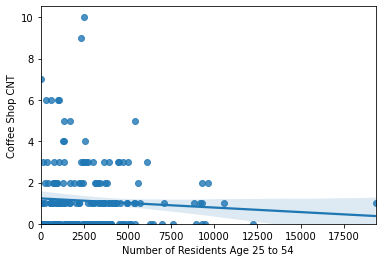

In [37]:
# 'Number of Residents Age 25 to 54' as potential predictor variable of 'Coffee Shop CNT'
sns.regplot(x="Number of Residents Age 25 to 54", y="Coffee Shop CNT", data=yyc2019merge)
plt.ylim(0,)

From the calculated correlation value of -.075605 as well as the results from the regression plot, it is determined that the variable of "Number of Residents Age 25 to 54" is not a good predictor for "Number of Coffee Shops" in a given neighborhood. The resulting regression line is essentially horizontal.  

This is a reasonable result as although a given neighborhood has a high demographic count of inidividuals in the prime coffee drinking age group, it does not translate to a high number of coffee shops in that particular neighborhood.  This may be due to additional factors such as changing demographics of a given area, municipal legislative considerations such as commercial zoning, etc.  

## Data Segmentation and Clustering

For better segmentation and clustering study, average & median household income by yyc neighborhood was collected from The Canadian Mortgage and Housing Corporation (CMHC).  The CMHC was able to provide household income data processed from 2016 Statistics Canada census data.  Please note since the income data for 2019 was not available, the 2016 data was deemed sufficient for the yyc neighborhood segmentation and clustering purposes.  

Important to note, the 2016 income data does not have income data on every neighborhood in Calgary (235), but contain data for 180 neighborhoods.  This should be sufficient for the purposes of this study since it captured majority of the yyc neighborhoods and would provide enough data for clustering.  

## Find Optimal K for K-means clustering

In [38]:
#load the income dataset into new dataframe
yyc2016inc = pd.read_excel('YYC2016Inc.xlsx', index_col=0)  
yyc2016inc.head()

NAME  Average Household Income After Taxes  \
0         LEGACY                                113658   
1  HIGHLAND PARK                                 82832   
2     MONTGOMERY                                 97159   
3         TEMPLE                                 79742   
4       WOODBINE                                128229   

   Median Household Income After Taxes  
0                                95756  
1                                64353  
2                                67458  
3                                72270  
4                                94028

In [39]:
#Merge the income dataframe with the yyc2019merge dataframe
yyc2019m2 = yyc2019merge.merge(yyc2016inc,how='left', left_on='NAME', right_on='NAME')
yyc2019m2.head()

CLASS           NAME     SECTOR RES_CNT  \
0  Residential         LEGACY      SOUTH    6420   
1  Residential  HIGHLAND PARK     CENTRE    3838   
2  Residential    CORNERSTONE  NORTHEAST    2648   
3  Residential     MONTGOMERY  NORTHWEST    4515   
4  Residential         TEMPLE  NORTHEAST   10977   

   Number of Residents Age 25 to 54   Latitude   Longitude  Coffee Shop CNT  \
0                              3446  50.856893 -114.002560              0.0   
1                              2060  51.085355 -114.065809              0.0   
2                              1461  51.160280 -113.939608              0.0   
3                              2319  51.074802 -114.162474              2.0   
4                              4646  51.088424 -113.947877              0.0   

   Average Household Income After Taxes  Median Household Income After Taxes  
0                              113658.0                              95756.0  
1                               82832.0                              64353.0  
2                                   NaN                                  NaN  
3                               97159.0                              67458.0  
4                               79742.0                              72270.0

In [40]:
#Drop the dataset for neighborhoods that does not have income data
yyc_final = yyc2019m2.dropna()
yyc_final.head()

CLASS           NAME     SECTOR RES_CNT  \
0  Residential         LEGACY      SOUTH    6420   
1  Residential  HIGHLAND PARK     CENTRE    3838   
3  Residential     MONTGOMERY  NORTHWEST    4515   
4  Residential         TEMPLE  NORTHEAST   10977   
5  Residential       WOODBINE      SOUTH    8866   

   Number of Residents Age 25 to 54   Latitude   Longitude  Coffee Shop CNT  \
0                              3446  50.856893 -114.002560              0.0   
1                              2060  51.085355 -114.065809              0.0   
3                              2319  51.074802 -114.162474              2.0   
4                              4646  51.088424 -113.947877              0.0   
5                              3316  50.942554 -114.128853              1.0   

   Average Household Income After Taxes  Median Household Income After Taxes  
0                              113658.0                              95756.0  
1                               82832.0                              64353.0  
3                               97159.0                              67458.0  
4                               79742.0                              72270.0  
5                              128229.0                              94028.0

In [41]:
yyc_final.shape

(167, 10)

### K-means pre-processing 

In [42]:
#Drop columns that can't be used for K-means
km = yyc_final.drop(['CLASS','NAME','SECTOR','Latitude','Longitude', 'Coffee Shop CNT'], axis=1)
km.head()

RES_CNT  Number of Residents Age 25 to 54  \
0    6420                              3446   
1    3838                              2060   
3    4515                              2319   
4   10977                              4646   
5    8866                              3316   

   Average Household Income After Taxes  Median Household Income After Taxes  
0                              113658.0                              95756.0  
1                               82832.0                              64353.0  
3                               97159.0                              67458.0  
4                               79742.0                              72270.0  
5                              128229.0                              94028.0

### Normalizing over the standard deviation
Normalization is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally. We use StandardScaler() to normalize our dataset.

In [43]:
from sklearn.preprocessing import StandardScaler
X = km.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[ 1.15590410e-01, -8.12907941e-02,  5.89270850e-01],
       [-4.04485545e-01, -8.19494490e-01, -1.11579002e+00],
       [-3.07299634e-01, -4.76399559e-01, -9.47200589e-01],
       [ 5.65872622e-01, -8.93492071e-01, -6.85927687e-01],
       [ 6.68098368e-02,  2.67647312e-01,  4.95447165e-01],
       [-6.93791866e-01, -4.76399559e-01, -9.47200589e-01],
       [ 1.89886975e-01, -1.20789797e+00, -1.81892470e+00],
       [-8.74279986e-01,  4.12251416e+00,  1.46615309e+00],
       [ 7.00206815e-01,  1.60774589e+00,  2.85260437e+00],
       [-1.08966498e+00, -1.98609288e-01, -2.57096978e-01],
       [-8.31127941e-01, -4.67179796e-01, -6.79629338e-01],
       [-7.75217900e-01, -4.67179796e-01, -6.79629338e-01],
       [-8.92291275e-01,  1.01083207e+00, -8.20147682e-01],
       [ 1.11409121e+00, -8.12907941e-02,  5.89270850e-01],
       [ 1.26847465e-01,  2.67647312e-01,  4.95447165e-01],
       [-2.06736607e-01, -3.19639636e-01, -1.13408781e+00],
       [ 7.67749147e-01, -1.02848377e+00

## Modeling

In [44]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(Clus_dataSet)
    distortions.append(kmeanModel.inertia_)

### Plot the distortions of K-Means

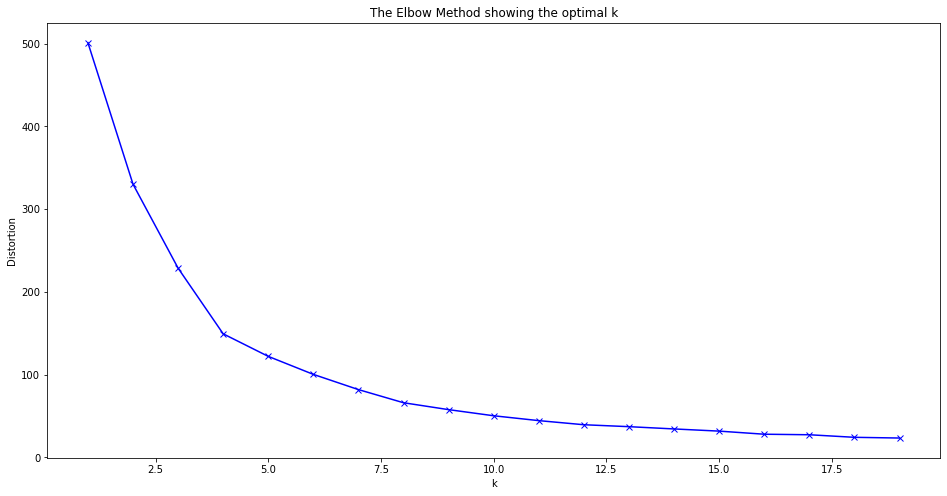

In [45]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

K-Means is an unsupervised machine learning algorithm that groups data into k number of clusters. The number of clusters is user-defined and the algorithm will try to group the data even if this number is not optimal for the specific case.

The Elbow method is a very popular technique and the idea is to run k-means clustering for a range of clusters k (let’s say from 1 to 20) and for each value, we are calculating the sum of squared distances from each point to its assigned center(distortions).

When the distortions are plotted and the plot looks like an arm then the “elbow”(the point of inflection on the curve) is the best value of k.

For this particular study, optimal K was determined to be 4 as there were no more substantial drops in distortion past the K value of 10 (Curve starts flattening after K = 4)

In [46]:
#Complete K-means with optimal K-value of 10 and retreive the cluster labels
clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(Clus_dataSet)
labels = k_means.labels_
print(labels)

[0 1 1 1 0 1 1 3 3 1 1 1 1 2 0 1 1 3 0 1 0 1 1 1 3 1 0 2 1 1 0 2 1 1 0 0 0
 0 1 1 1 2 0 1 0 2 0 1 1 1 0 1 2 1 2 1 0 0 1 1 1 2 1 1 1 0 0 1 0 1 1 1 3 1
 1 0 3 1 1 0 0 0 2 0 0 0 0 0 1 3 0 1 2 0 0 1 0 0 0 0 0 1 1 0 0 2 0 1 1 3 1
 0 0 0 1 0 0 1 1 1 1 2 2 0 0 1 0 1 1 1 1 1 0 0 2 1 0 1 1 0 0 2 1 1 1 3 1 1
 2 0 0 3 1 1 1 1 1 1 2 0 3 1 1 2 3 0 0]


In [47]:
#Set new column in the yyc_final dataframe with the cluster labels
yyc_final["Clus_km"] = labels
yyc_final.head()

<ipython-input-47-799b8d8f022f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yyc_final["Clus_km"] = labels


CLASS           NAME     SECTOR RES_CNT  \
0  Residential         LEGACY      SOUTH    6420   
1  Residential  HIGHLAND PARK     CENTRE    3838   
3  Residential     MONTGOMERY  NORTHWEST    4515   
4  Residential         TEMPLE  NORTHEAST   10977   
5  Residential       WOODBINE      SOUTH    8866   

   Number of Residents Age 25 to 54   Latitude   Longitude  Coffee Shop CNT  \
0                              3446  50.856893 -114.002560              0.0   
1                              2060  51.085355 -114.065809              0.0   
3                              2319  51.074802 -114.162474              2.0   
4                              4646  51.088424 -113.947877              0.0   
5                              3316  50.942554 -114.128853              1.0   

   Average Household Income After Taxes  Median Household Income After Taxes  \
0                              113658.0                              95756.0   
1                               82832.0                              64353.0   
3                               97159.0                              67458.0   
4                               79742.0                              72270.0   
5                              128229.0                              94028.0   

   Clus_km  
0        0  
1        1  
3        1  
4        1  
5        0

## Choropleth Maps

A Choropleth map is a thematic map in which areas are shaded or patterned in proportion to the measurement of the statistical variable being displayed on the map, such as population density or per-capita income. The choropleth map provides an easy way to visualize how a measurement varies across a geographic area or it shows the level of variability within a region.

### Choropleth Map by Target Demographic (Residents Age 25 to 54) Count

In [51]:
url = ('https://raw.githubusercontent.com/camstark/calgis/gh-pages')
state_geo = f'{url}/community-2016-simple.json'

In [54]:
df_demo = yyc_final.drop(['CLASS','SECTOR','RES_CNT','Latitude','Longitude', 'Clus_km'],axis=1)
df_demo.head()

NAME  Number of Residents Age 25 to 54  Coffee Shop CNT  \
0         LEGACY                              3446              0.0   
1  HIGHLAND PARK                              2060              0.0   
3     MONTGOMERY                              2319              2.0   
4         TEMPLE                              4646              0.0   
5       WOODBINE                              3316              1.0   

   Average Household Income After Taxes  Median Household Income After Taxes  
0                              113658.0                              95756.0  
1                               82832.0                              64353.0  
3                               97159.0                              67458.0  
4                               79742.0                              72270.0  
5                              128229.0                              94028.0

In [55]:
# Calgary latitude and longitude values
latitude = 51.0534234
longitude = -114.0625892


#Target Demographic count Choropleth Map
yyc_map = folium.Map(location=[latitude, longitude], zoom_start=12)

yyc_map.choropleth(

geo_data=state_geo,

name="choropleth",

data=df_demo,

columns=['NAME','Number of Residents Age 25 to 54'],

key_on="feature.properties.name",

fill_color="YlGn",

fill_opacity=0.7,

line_opacity=0.2,

    legend_name="Target Demographic Count in Calgary",

)

yyc_map

C:\Users\raymo\anaconda3\lib\site-packages\folium\folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [56]:
#YYC Coffee Shop count Choropleth Map
yyc_map1 = folium.Map(location=[latitude, longitude], zoom_start=12)

yyc_map1.choropleth(

geo_data=state_geo,

name="choropleth",

data=df_demo,

columns=['NAME','Coffee Shop CNT'],

key_on="feature.properties.name",

fill_color="BuGn",

fill_opacity=0.7,

line_opacity=0.2,

    legend_name="Coffee Shop Count in Calgary",

)

yyc_map1

In [58]:
#YYC Coffee Shop count Choropleth Map
yyc_map2 = folium.Map(location=[latitude, longitude], zoom_start=12)

yyc_map2.choropleth(

geo_data=state_geo,

name="choropleth",

data=df_demo,

columns=['NAME','Average Household Income After Taxes'],

key_on="feature.properties.name",

fill_color="BuPu",

fill_opacity=0.7,

line_opacity=0.2,

    legend_name="Average After Tax Household Income in Calgary",

)

yyc_map2

In [59]:
#Median After Tax Household Income in Calgary - Choropleth Map
yyc_map3 = folium.Map(location=[latitude, longitude], zoom_start=12)

yyc_map3.choropleth(

geo_data=state_geo,

name="choropleth",

data=df_demo,

columns=['NAME','Median Household Income After Taxes'],

key_on="feature.properties.name",

fill_color="BuPu",

fill_opacity=0.7,

line_opacity=0.2,

    legend_name="Median After Tax Household Income in Calgary",

)

yyc_map3

## Map the final clustering results

In [47]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(yyc_final['Latitude'], yyc_final['Longitude'], yyc_final['NAME'], yyc_final['Clus_km']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine the Clusters

### Cluster 1

In [48]:
clus1 = yyc_final.loc[yyc_final['Clus_km'] == 0, yyc_final.columns[[1] + list(range(3, yyc_final.shape[1]))]]
clus1.head()

NAME RES_CNT  Number of Residents Age 25 to 54   Latitude  \
15        BRIDLEWOOD   12641                              6107  50.900713   
30    MCKENZIE TOWNE   18283                              9323  50.916499   
34        AUBURN BAY   17607                              9277  50.890605   
46          TARADALE   19026                              8931  51.116704   
53  HUNTINGTON HILLS   13420                              5723  51.118724   

     Longitude  Coffee Shop CNT  Average Household Income After Taxes  \
15 -114.110515              3.0                              113658.0   
30 -113.964353              2.0                              119066.0   
34 -113.959565              0.0                              119066.0   
46 -113.938464              0.0                               86344.0   
53 -114.068288              1.0                               99403.0   

    Median Household Income After Taxes  Clus_km  
15                              95756.0        0  
30                             101028.0        0  
34                             101028.0        0  
46                              78960.0        0  
53                              89515.0        0

In [49]:
# Get names of indexes for which column Coffee Shop CNT that has non 0 values
# Identify neighborhoods that doesn't have existing coffee shops
indexNAc1 = clus1[ clus1['Coffee Shop CNT'] != 0 ].index
# Delete these row indexes from dataFrame
clus1.drop(indexNAc1 , inplace=True)
clus1.head()

NAME RES_CNT  Number of Residents Age 25 to 54   Latitude  \
34      AUBURN BAY   17607                              9277  50.890605   
46        TARADALE   19026                              8931  51.116704   
62   SKYVIEW RANCH   11707                              6484  51.160534   
110    COPPERFIELD   13823                              7618  50.912048   
155       MAHOGANY   11784                              6296  50.898702   

      Longitude  Coffee Shop CNT  Average Household Income After Taxes  \
34  -113.959565              0.0                              119066.0   
46  -113.938464              0.0                               86344.0   
62  -113.958135              0.0                               86344.0   
110 -113.932098              0.0                              119066.0   
155 -113.925905              0.0                              119066.0   

     Median Household Income After Taxes  Clus_km  
34                              101028.0        0  
46                               78960.0        0  
62                               78960.0        0  
110                             101028.0        0  
155                             101028.0        0

In [50]:
clus1.shape

(8, 9)

In [51]:
clus1g1 = clus1.drop(['Latitude','Longitude', 'Coffee Shop CNT', 'Clus_km'], axis=1)
clus1g1.head() 

NAME RES_CNT  Number of Residents Age 25 to 54  \
34      AUBURN BAY   17607                              9277   
46        TARADALE   19026                              8931   
62   SKYVIEW RANCH   11707                              6484   
110    COPPERFIELD   13823                              7618   
155       MAHOGANY   11784                              6296   

     Average Household Income After Taxes  Median Household Income After Taxes  
34                               119066.0                             101028.0  
46                                86344.0                              78960.0  
62                                86344.0                              78960.0  
110                              119066.0                             101028.0  
155                              119066.0                             101028.0

In [52]:
clus1g1.describe()

Number of Residents Age 25 to 54  Average Household Income After Taxes  \
count                          8.000000                              8.000000   
mean                        8410.250000                         103661.375000   
std                         1981.771196                          15719.178977   
min                         6296.000000                          86344.000000   
25%                         6862.000000                          86344.000000   
50%                         8274.500000                         106530.500000   
75%                         9324.500000                         119066.000000   
max                        12221.000000                         119066.000000   

       Median Household Income After Taxes  
count                             8.000000  
mean                          90654.375000  
std                           10422.751624  
min                           78960.000000  
25%                           78960.000000  
50%                           92635.500000  
75%                          101028.000000  
max                          101028.000000

As it can be observed from the above table, cluster 1 neighborhoods can be categorized with the following attributes.  These are neighborhoods that has a 'Average Household Income After Taxes' of approximately 130,000 and a 'Median Household Income After Taxes' of approximately 97,000.  The average number of residents in the target demographic group (Age 25 to 54) is approximately 2700.   

In [53]:
#Output the Cluster 1 dataframe in excel to inspect the data
clus1g1.to_excel("Cluster1.xlsx")

In [54]:
clus1g1['Percentage of Target Demographic'] = clus1g1['Number of Residents Age 25 to 54']/clus1g1['RES_CNT']
clus1g1.head()                                                

NAME RES_CNT  Number of Residents Age 25 to 54  \
34      AUBURN BAY   17607                              9277   
46        TARADALE   19026                              8931   
62   SKYVIEW RANCH   11707                              6484   
110    COPPERFIELD   13823                              7618   
155       MAHOGANY   11784                              6296   

     Average Household Income After Taxes  \
34                               119066.0   
46                                86344.0   
62                                86344.0   
110                              119066.0   
155                              119066.0   

     Median Household Income After Taxes Percentage of Target Demographic  
34                              101028.0                         0.526893  
46                               78960.0                          0.46941  
62                               78960.0                         0.553857  
110                             101028.0                          0.55111  
155                             101028.0                         0.534284

In [55]:
##Sort the data in descending order 
result1 = clus1g1.drop(['RES_CNT','Number of Residents Age 25 to 54','Average Household Income After Taxes','Median Household Income After Taxes'], axis=1)
result1.sort_values(['Percentage of Target Demographic'],ascending=False, axis=0, inplace=True)
result1.set_index(['NAME'])

Percentage of Target Demographic
NAME                                           
SKYVIEW RANCH                          0.553857
COPPERFIELD                             0.55111
MAHOGANY                               0.534284
AUBURN BAY                             0.526893
MARTINDALE                             0.490558
PANORAMA HILLS                          0.47534
TARADALE                                0.46941
EVERGREEN                              0.440326

### Generate Graphs for analysis

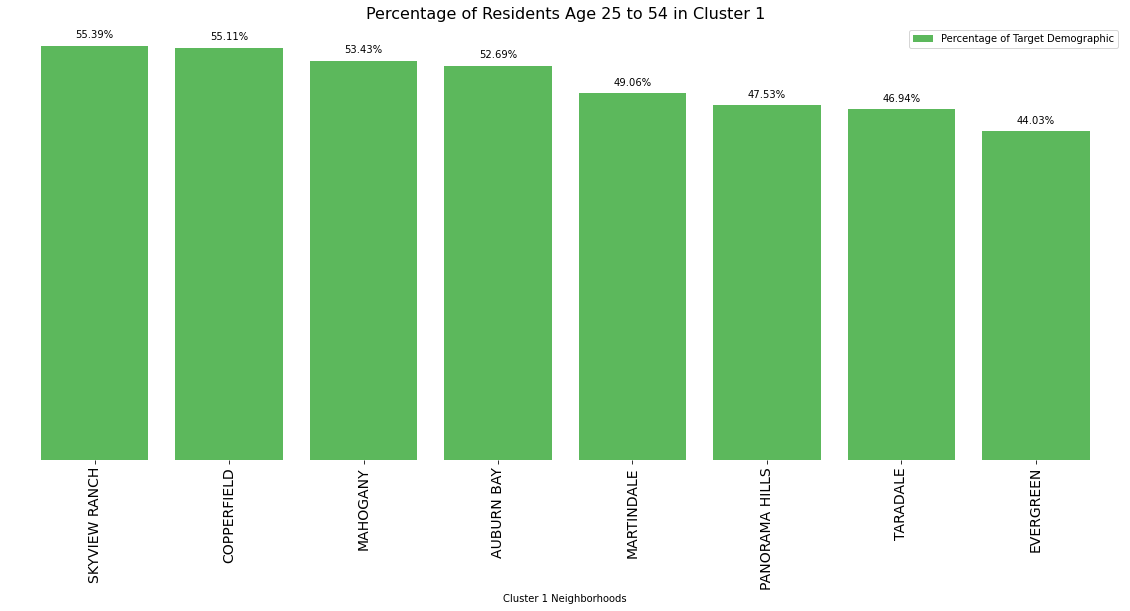

In [56]:
colors_list = ['#5cb85c']

#Plot Bar chart with required specifications
ax1 = result1.plot(kind='bar', use_index=True, figsize=(20,8),width = 0.8,color = colors_list,edgecolor=None)
ax1.set_xticklabels(result1['NAME'])
ax1.set_xlabel('Cluster 1 Neighborhoods')
plt.title("Percentage of Residents Age 25 to 54 in Cluster 1",fontsize= 16)

#Remove the left, Top and Right borders of the bars
plt.xticks(fontsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the % annotations above the bars
for p in ax1.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax1.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center')

Using percentage for graphing purposes is a good way to visualize the demographic of the neighborhood in comparison to each other.  However, it is important to note that a neighborhood can have a lower target demographic percentage, but actually have a above average NUMBER of residents in the target demographic group.  

### Filter and Graph the TOP 3 Ideal Neighborhoods in Cluster 1
Criteria:

Above cluster average number of residents Age 25 to 54 (Average = 2610)

Above cluster average after taxes average household income (Average = 87573.71)

Above cluster average after taxes median household income (Average = 69628.53)

Order of Priority for selection is Median After Tax Income, Number of Target Demographic, Average After Tax Income

In [59]:
#Graph the income data for Cluster 1
inc_c1 = clus1g1.drop(['RES_CNT','Percentage of Target Demographic'], axis=1)
inc_c1.sort_values(['Average Household Income After Taxes'],ascending=False, axis=0, inplace=True)

# Filter for ideal neighborhood in cluster based on avobe criteria
# Filter for Target Demographic
index_inc1_c1 = inc_c1[ inc_c1['Number of Residents Age 25 to 54'] < 8410 ].index
# Delete these row indexes from dataFrame
inc_c1.drop(index_inc1_c1 , inplace=True)

#Filter for Average Household Income
index_inc2_c1 = inc_c1[ inc_c1['Average Household Income After Taxes'] < 103661.38 ].index
# Delete these row indexes from dataFrame
inc_c1.drop(index_inc2_c1 , inplace=True)

#Filter for Median Household Income
index_inc3_c1 = inc_c1[ inc_c1['Median Household Income After Taxes'] <= 90654.38 ].index
# Delete these row indexes from dataFrame
inc_c1.drop(index_inc3_c1 , inplace=True)

inc_c1.set_index(['NAME'])

Number of Residents Age 25 to 54  \
NAME                                           
AUBURN BAY                              9277   
EVERGREEN                               9467   

            Average Household Income After Taxes  \
NAME                                               
AUBURN BAY                              119066.0   
EVERGREEN                               113658.0   

            Median Household Income After Taxes  
NAME                                             
AUBURN BAY                             101028.0  
EVERGREEN                               95756.0

Text(0.5, 1.0, 'Top 3 Potential Neighborhoods in Cluster 1')

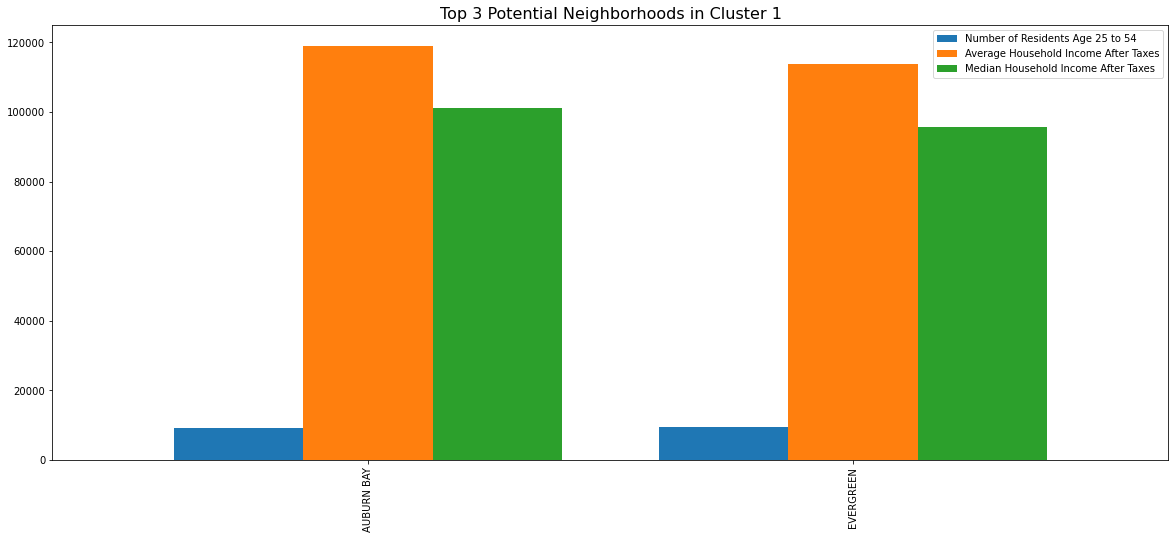

In [60]:
ax1_inc = inc_c1.plot.bar(rot=0,figsize=(20,8),width = 0.8)
ax1_inc.set_xticklabels(inc_c1['NAME'])
plt.xticks(rotation=90)
plt.title("Top 3 Potential Neighborhoods in Cluster 1",fontsize= 16)

The desire is to identify neighborhoods of high potential in cluster 1.  As such, the coffee shop franchise client would be interested in neighborhoods that does not have existing coffee shops, high number of residents who are in the target demographic group and high average & median household income.  

### Cluster 2

In [61]:
clus2 = yyc_final.loc[yyc_final['Clus_km'] == 1, yyc_final.columns[[1] + list(range(3, yyc_final.shape[1]))]]
clus2.head()

NAME RES_CNT  Number of Residents Age 25 to 54   Latitude  \
9   KELVIN GROVE    2305                               808  50.990874   
10  WEST SPRINGS   10758                              5004  51.058822   
20   ASPEN WOODS    9446                              4484  51.043119   
27  COUGAR RIDGE    6997                              3392  51.070710   
88     CRESTMONT    1690                               830  51.085215   

     Longitude  Coffee Shop CNT  Average Household Income After Taxes  \
9  -114.084830              2.0                              289201.0   
10 -114.204254              3.0                              184189.0   
20 -114.210185              3.0                              184189.0   
27 -114.210968              0.0                              184189.0   
88 -114.265072              0.0                              184189.0   

    Median Household Income After Taxes  Clus_km  
9                              111906.0        1  
10                             137441.0        1  
20                             137441.0        1  
27                             137441.0        1  
88                             137441.0        1

In [62]:
# Get names of indexes for which column Coffee Shop CNT that has non 0 values
# Identify neighborhoods that doesn't have existing coffee shops
indexNAc2 = clus2[ clus2['Coffee Shop CNT'] != 0 ].index
# Delete these row indexes from dataFrame
clus2.drop(indexNAc2 , inplace=True)
clus2.head()

NAME RES_CNT  Number of Residents Age 25 to 54   Latitude  \
27      COUGAR RIDGE    6997                              3392  51.070710   
88         CRESTMONT    1690                               830  51.085215   
92      VALLEY RIDGE    5585                              2117  51.094066   
137      EAGLE RIDGE     302                                80  50.985116   
185  DISCOVERY RIDGE    4280                              1637  51.014140   

      Longitude  Coffee Shop CNT  Average Household Income After Taxes  \
27  -114.210968              0.0                              184189.0   
88  -114.265072              0.0                              184189.0   
92  -114.251627              0.0                              184189.0   
137 -114.099152              0.0                              289201.0   
185 -114.207297              0.0                              184189.0   

     Median Household Income After Taxes  Clus_km  
27                              137441.0        1  
88                              137441.0        1  
92                              137441.0        1  
137                             111906.0        1  
185                             137441.0        1

In [63]:
clus2.shape

(7, 9)

In [64]:
clus2g1 = clus2.drop(['Latitude','Longitude', 'Coffee Shop CNT', 'Clus_km'], axis=1)
clus2g1.head() 

NAME RES_CNT  Number of Residents Age 25 to 54  \
27      COUGAR RIDGE    6997                              3392   
88         CRESTMONT    1690                               830   
92      VALLEY RIDGE    5585                              2117   
137      EAGLE RIDGE     302                                80   
185  DISCOVERY RIDGE    4280                              1637   

     Average Household Income After Taxes  Median Household Income After Taxes  
27                               184189.0                             137441.0  
88                               184189.0                             137441.0  
92                               184189.0                             137441.0  
137                              289201.0                             111906.0  
185                              184189.0                             137441.0

In [65]:
clus2g1.describe()

Number of Residents Age 25 to 54  Average Household Income After Taxes  \
count                          7.000000                              7.000000   
mean                        1185.285714                         229194.142857   
std                         1262.102177                          56131.275071   
min                           80.000000                         184189.000000   
25%                          120.500000                         184189.000000   
50%                          830.000000                         184189.000000   
75%                         1877.000000                         289201.000000   
max                         3392.000000                         289201.000000   

       Median Household Income After Taxes  
count                             7.000000  
mean                         126497.428571  
std                           13649.031624  
min                          111906.000000  
25%                          111906.000000  
50%                          137441.000000  
75%                          137441.000000  
max                          137441.000000

In [66]:
#Output the Cluster 2 dataframe in excel to inspect the data
clus2g1.to_excel("Cluster2.xlsx")

In [67]:
clus2g1['Percentage of Target Demographic'] = clus2g1['Number of Residents Age 25 to 54']/clus2g1['RES_CNT']
clus2g1.head()     

NAME RES_CNT  Number of Residents Age 25 to 54  \
27      COUGAR RIDGE    6997                              3392   
88         CRESTMONT    1690                               830   
92      VALLEY RIDGE    5585                              2117   
137      EAGLE RIDGE     302                                80   
185  DISCOVERY RIDGE    4280                              1637   

     Average Household Income After Taxes  \
27                               184189.0   
88                               184189.0   
92                               184189.0   
137                              289201.0   
185                              184189.0   

     Median Household Income After Taxes Percentage of Target Demographic  
27                              137441.0                         0.484779  
88                              137441.0                         0.491124  
92                              137441.0                         0.379051  
137                             111906.0                         0.264901  
185                             137441.0                         0.382477

In [68]:
##Sort the data in descending order 
result2 = clus2g1.drop(['RES_CNT','Number of Residents Age 25 to 54','Average Household Income After Taxes','Median Household Income After Taxes'], axis=1)
result2.sort_values(['Percentage of Target Demographic'],ascending=False, axis=0, inplace=True)
result2.set_index(['NAME'])

Percentage of Target Demographic
NAME                                            
CRESTMONT                               0.491124
COUGAR RIDGE                            0.484779
DISCOVERY RIDGE                         0.382477
VALLEY RIDGE                            0.379051
MAYFAIR                                 0.305556
BEL-AIRE                                0.279487
EAGLE RIDGE                             0.264901

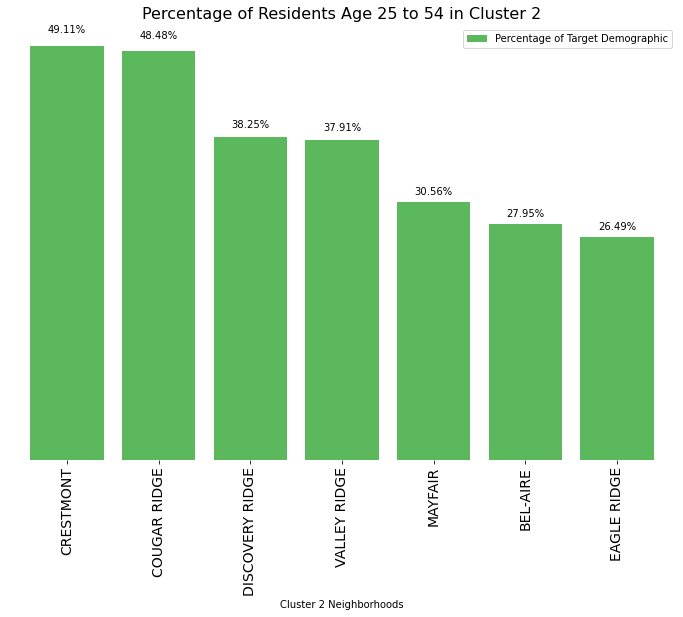

In [69]:
colors_list = ['#5cb85c']

#Plot Bar chart with required specifications
ax2 = result2.plot(kind='bar', use_index=True, figsize=(12,8),width = 0.8,color = colors_list,edgecolor=None)
ax2.set_xticklabels(result2['NAME'])
ax2.set_xlabel('Cluster 2 Neighborhoods')
plt.title("Percentage of Residents Age 25 to 54 in Cluster 2",fontsize= 16)

#Remove the left, Top and Right borders of the bars
plt.xticks(fontsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the % annotations above the bars
for p in ax2.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax2.annotate(f'{height:.2%}', (x + width/2, y + height*1.03), ha='center')

In [70]:
#Graph the income data for Cluster 2
inc_c2 = clus2g1.drop(['RES_CNT','Percentage of Target Demographic'], axis=1)
inc_c2.sort_values(['Average Household Income After Taxes'],ascending=False, axis=0, inplace=True)

# Filter for ideal neighborhood in cluster based on avobe criteria
# Filter for Target Demographic
index_inc1_c2 = inc_c2[ inc_c2['Number of Residents Age 25 to 54'] < 1186 ].index
# Delete these row indexes from dataFrame
inc_c2.drop(index_inc1_c2 , inplace=True)

#Filter for Median Household Income
index_inc3_c2 = inc_c2[ inc_c2['Median Household Income After Taxes'] <= 126497.43 ].index
# Delete these row indexes from dataFrame
inc_c2.drop(index_inc3_c2 , inplace=True)

inc_c2.set_index(['NAME'])

Number of Residents Age 25 to 54  \
NAME                                                
COUGAR RIDGE                                 3392   
VALLEY RIDGE                                 2117   
DISCOVERY RIDGE                              1637   

                 Average Household Income After Taxes  \
NAME                                                    
COUGAR RIDGE                                 184189.0   
VALLEY RIDGE                                 184189.0   
DISCOVERY RIDGE                              184189.0   

                 Median Household Income After Taxes  
NAME                                                  
COUGAR RIDGE                                137441.0  
VALLEY RIDGE                                137441.0  
DISCOVERY RIDGE                             137441.0

Text(0.5, 1.0, 'Top 2 Potential Neighborhoods in Cluster 2')

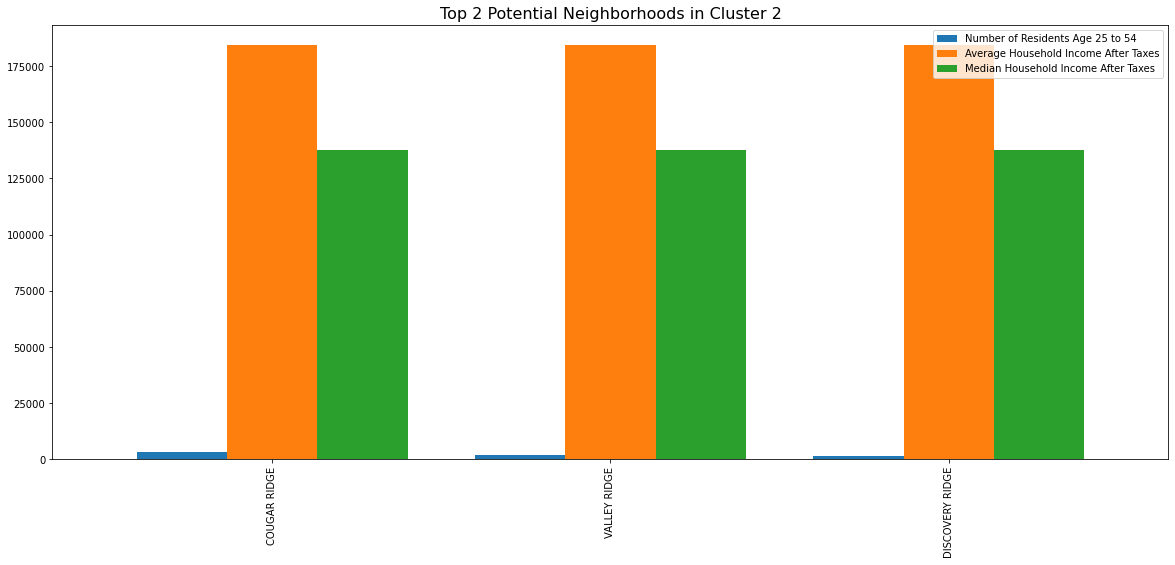

In [71]:
ax2_inc = inc_c2.plot.bar(rot=0,figsize=(20,8),width = 0.8)
ax2_inc.set_xticklabels(inc_c2['NAME'])
plt.xticks(rotation=90)
plt.title("Top 2 Potential Neighborhoods in Cluster 2",fontsize= 16)

### Cluster 3

In [72]:
clus3 = yyc_final.loc[yyc_final['Clus_km'] == 2, yyc_final.columns[[1] + list(range(3, yyc_final.shape[1]))]]
clus3.head()

NAME RES_CNT  Number of Residents Age 25 to 54   Latitude  \
0           LEGACY    6420                              3446  50.856893   
5         WOODBINE    8866                              3316  50.942554   
16  LAKE BONAVISTA   10293                              3476  50.939987   
21        RICHMOND    4962                              2722  51.031439   
23        SOMERSET    8543                              3879  50.898742   

     Longitude  Coffee Shop CNT  Average Household Income After Taxes  \
0  -114.002560              0.0                              113658.0   
5  -114.128853              1.0                              128229.0   
16 -114.051475              0.0                              128229.0   
21 -114.115487              0.0                              168571.0   
23 -114.083368              0.0                              113658.0   

    Median Household Income After Taxes  Clus_km  
0                               95756.0        2  
5                               94028.0        2  
16                              94028.0        2  
21                              93522.0        2  
23                              95756.0        2

In [73]:
# Get names of indexes for which column Coffee Shop CNT that has non 0 values
# Identify neighborhoods that doesn't have existing coffee shops
indexNAc3 = clus3[ clus3['Coffee Shop CNT'] != 0 ].index
# Delete these row indexes from dataFrame
clus3.drop(indexNAc3 , inplace=True)

clus3.head()

NAME RES_CNT  Number of Residents Age 25 to 54   Latitude  \
0           LEGACY    6420                              3446  50.856893   
16  LAKE BONAVISTA   10293                              3476  50.939987   
21        RICHMOND    4962                              2722  51.031439   
23        SOMERSET    8543                              3879  50.898742   
33       SHAWNESSY    9368                              3992  50.908539   

     Longitude  Coffee Shop CNT  Average Household Income After Taxes  \
0  -114.002560              0.0                              113658.0   
16 -114.051475              0.0                              128229.0   
21 -114.115487              0.0                              168571.0   
23 -114.083368              0.0                              113658.0   
33 -114.085165              0.0                              113658.0   

    Median Household Income After Taxes  Clus_km  
0                               95756.0        2  
16                              94028.0        2  
21                              93522.0        2  
23                              95756.0        2  
33                              95756.0        2

In [74]:
clus3.shape

(32, 9)

In [75]:
clus3g1 = clus3.drop(['Latitude','Longitude', 'Coffee Shop CNT', 'Clus_km'], axis=1)
clus3g1.head() 

NAME RES_CNT  Number of Residents Age 25 to 54  \
0           LEGACY    6420                              3446   
16  LAKE BONAVISTA   10293                              3476   
21        RICHMOND    4962                              2722   
23        SOMERSET    8543                              3879   
33       SHAWNESSY    9368                              3992   

    Average Household Income After Taxes  Median Household Income After Taxes  
0                               113658.0                              95756.0  
16                              128229.0                              94028.0  
21                              168571.0                              93522.0  
23                              113658.0                              95756.0  
33                              113658.0                              95756.0

In [76]:
clus3g1.describe()

Number of Residents Age 25 to 54  Average Household Income After Taxes  \
count                         32.000000                              32.00000   
mean                        2689.843750                          127925.03125   
std                         1287.048239                           17678.39925   
min                          199.000000                           99403.00000   
25%                         1831.750000                          113658.00000   
50%                         3011.500000                          128229.00000   
75%                         3453.500000                          136615.00000   
max                         5432.000000                          168571.00000   

       Median Household Income After Taxes  
count                            32.000000  
mean                          96680.000000  
std                            5717.470454  
min                           87601.000000  
25%                           93901.500000  
50%                           95756.000000  
75%                           97152.750000  
max                          110614.000000

In [77]:
#Output the Cluster 3 dataframe in excel to inspect the data
clus3g1.to_excel("Cluster3.xlsx")

In [78]:
clus3g1['Percentage of Target Demographic'] = clus3g1['Number of Residents Age 25 to 54']/clus3g1['RES_CNT']
clus3g1.head()    

NAME RES_CNT  Number of Residents Age 25 to 54  \
0           LEGACY    6420                              3446   
16  LAKE BONAVISTA   10293                              3476   
21        RICHMOND    4962                              2722   
23        SOMERSET    8543                              3879   
33       SHAWNESSY    9368                              3992   

    Average Household Income After Taxes  Median Household Income After Taxes  \
0                               113658.0                              95756.0   
16                              128229.0                              94028.0   
21                              168571.0                              93522.0   
23                              113658.0                              95756.0   
33                              113658.0                              95756.0   

   Percentage of Target Demographic  
0                           0.53676  
16                         0.337705  
21                         0.548569  
23                         0.454056  
33                         0.426132

In [79]:
##Sort the data in descending order 
result3 = clus3g1.drop(['RES_CNT','Number of Residents Age 25 to 54','Average Household Income After Taxes','Median Household Income After Taxes'], axis=1)
result3.sort_values(['Percentage of Target Demographic'],ascending=False, axis=0, inplace=True)
result3.set_index(['NAME'])

Percentage of Target Demographic
NAME                                                
RICHMOND                                    0.548569
LEGACY                                       0.53676
WALDEN                                      0.530989
SHERWOOD                                    0.495837
WEST HILLHURST                              0.485807
BONAVISTA DOWNS                             0.466595
RANCHLANDS                                  0.465361
SOMERSET                                    0.454056
QUEENSLAND                                  0.445288
ROCKY RIDGE                                 0.437366
HIDDEN VALLEY                               0.436798
SHAWNESSY                                   0.426132
CANYON MEADOWS                              0.425367
MILLRISE                                    0.424058
COACH HILL                                   0.41492
NORTH GLENMORE PARK                         0.403179
PATTERSON                                   0.395764
DEER RUN                                    0.385587
ARBOUR LAKE                                 0.381204
MACEWAN GLEN                                0.375684
SILVER SPRINGS                              0.364789
STRATHCONA PARK                             0.363822
EDGEMONT                                    0.352842
HAWKWOOD                                    0.352292
SUNDANCE                                    0.350657
LAKEVIEW                                    0.344911
LAKE BONAVISTA                              0.337705
HAMPTONS                                     0.33663
RIDEAU PARK                                 0.335017
ELBOW PARK                                  0.333333
SCENIC ACRES                                 0.33011
DIAMOND COVE                                0.308696

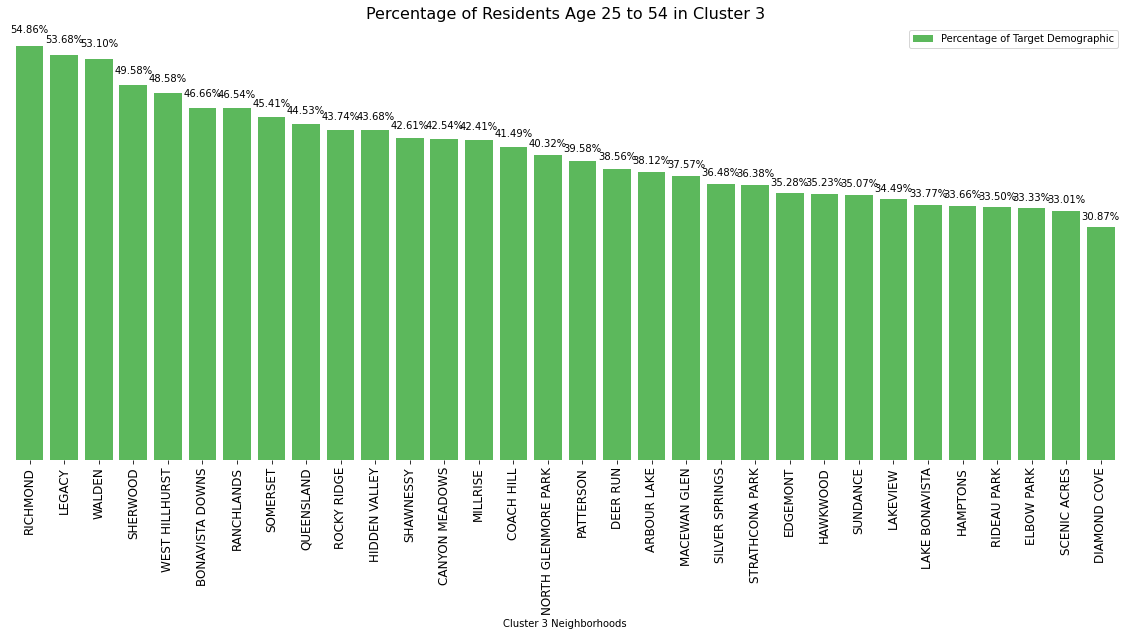

In [80]:
colors_list = ['#5cb85c']

#Plot Bar chart with required specifications
ax3 = result3.plot(kind='bar', use_index=True, figsize=(20,8),width = 0.8,color = colors_list,edgecolor=None)
ax3.set_xticklabels(result3['NAME'])
ax3.set_xlabel('Cluster 3 Neighborhoods')
plt.title("Percentage of Residents Age 25 to 54 in Cluster 3",fontsize= 16)

#Remove the left, Top and Right borders of the bars
plt.xticks(fontsize=12)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the % annotations above the bars
for p in ax3.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax3.annotate(f'{height:.2%}', (x + width/2, y + height*1.03), ha='center')

In [81]:
#Graph the income data for Cluster 3
inc_c3 = clus3g1.drop(['RES_CNT','Percentage of Target Demographic'], axis=1)
inc_c3.sort_values(['Average Household Income After Taxes'],ascending=False, axis=0, inplace=True)

# Filter for ideal neighborhood in cluster based on avobe criteria
# Filter for Target Demographic
index_inc1_c3 = inc_c3[ inc_c3['Number of Residents Age 25 to 54'] <= 2690 ].index
# Delete these row indexes from dataFrame
inc_c3.drop(index_inc1_c3 , inplace=True)

#Filter for Average Household Income
index_inc2_c3 = inc_c3[ inc_c3['Average Household Income After Taxes'] <= 127925.03 ].index
# Delete these row indexes from dataFrame
inc_c3.drop(index_inc2_c3 , inplace=True)

#Filter for Median Household Income
index_inc3_c3 = inc_c3[ inc_c3['Median Household Income After Taxes'] <= 96680 ].index
# Delete these row indexes from dataFrame
inc_c3.drop(index_inc3_c3 , inplace=True)

inc_c3.set_index(['NAME'])

Number of Residents Age 25 to 54  \
NAME                                               
SILVER SPRINGS                              3166   
EDGEMONT                                    5432   
SHERWOOD                                    3097   

                Average Household Income After Taxes  \
NAME                                                   
SILVER SPRINGS                              132035.0   
EDGEMONT                                    129218.0   
SHERWOOD                                    129218.0   

                Median Household Income After Taxes  
NAME                                                 
SILVER SPRINGS                             110614.0  
EDGEMONT                                   105839.0  
SHERWOOD                                   105839.0

Text(0.5, 1.0, 'Top 2 Potential Neighborhoods in Cluster 3')

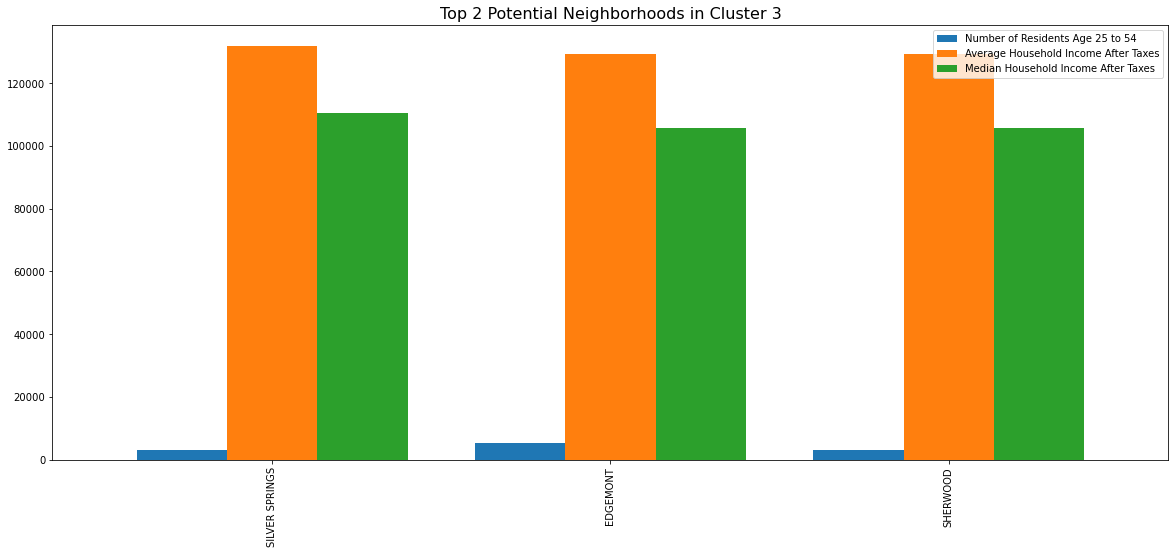

In [82]:
ax3_inc = inc_c3.plot.bar(rot=0,figsize=(20,8),width = 0.8)
ax3_inc.set_xticklabels(inc_c3['NAME'])
plt.xticks(rotation=90)
plt.title("Top 2 Potential Neighborhoods in Cluster 3",fontsize= 16)

### Cluster 4

In [84]:
clus4 = yyc_final.loc[yyc_final['Clus_km'] == 3, yyc_final.columns[[1] + list(range(3, yyc_final.shape[1]))]]
clus4.head()

NAME RES_CNT  Number of Residents Age 25 to 54   Latitude  \
1       HIGHLAND PARK    3838                              2060  51.085355   
3          MONTGOMERY    4515                              2319  51.074802   
4              TEMPLE   10977                              4646  51.088424   
6  UNIVERSITY HEIGHTS    2921                              1289  51.070740   
7            BANKVIEW    5256                              3644  51.033887   

    Longitude  Coffee Shop CNT  Average Household Income After Taxes  \
1 -114.065809              0.0                               82832.0   
3 -114.162474              2.0                               97159.0   
4 -113.947877              0.0                               79742.0   
6 -114.137231              2.0                               97159.0   
7 -114.099518              1.0                               66613.0   

   Median Household Income After Taxes  Clus_km  
1                              64353.0        3  
3                              67458.0        3  
4                              72270.0        3  
6                              67458.0        3  
7                              51403.0        3

In [85]:
# Get names of indexes for which column Coffee Shop CNT that has non 0 values
# Identify neighborhoods that doesn't have existing coffee shops
indexNAc4 = clus4[ clus4['Coffee Shop CNT'] != 0 ].index
# Delete these row indexes from dataFrame
clus4.drop(indexNAc4 , inplace=True)

clus4.head()

NAME RES_CNT  Number of Residents Age 25 to 54   Latitude  \
1   HIGHLAND PARK    3838                              2060  51.085355   
4          TEMPLE   10977                              4646  51.088424   
11        BAYVIEW     751                               234  50.973577   
12     SHAGANAPPI    1626                               923  51.042939   
13       WILDWOOD    2709                              1072  51.054508   

     Longitude  Coffee Shop CNT  Average Household Income After Taxes  \
1  -114.065809              0.0                               82832.0   
4  -113.947877              0.0                               79742.0   
11 -114.112561              0.0                              108759.0   
12 -114.124599              0.0                               97544.0   
13 -114.153229              0.0                               97544.0   

    Median Household Income After Taxes  Clus_km  
1                               64353.0        3  
4                               72270.0        3  
11                              80168.0        3  
12                              72386.0        3  
13                              72386.0        3

In [86]:
clus4.shape

(34, 9)

In [87]:
clus4g1 = clus4.drop(['Latitude','Longitude', 'Coffee Shop CNT', 'Clus_km'], axis=1)
clus4g1.head() 

NAME RES_CNT  Number of Residents Age 25 to 54  \
1   HIGHLAND PARK    3838                              2060   
4          TEMPLE   10977                              4646   
11        BAYVIEW     751                               234   
12     SHAGANAPPI    1626                               923   
13       WILDWOOD    2709                              1072   

    Average Household Income After Taxes  Median Household Income After Taxes  
1                                82832.0                              64353.0  
4                                79742.0                              72270.0  
11                              108759.0                              80168.0  
12                               97544.0                              72386.0  
13                               97544.0                              72386.0

In [88]:
clus4g1.describe()

Number of Residents Age 25 to 54  Average Household Income After Taxes  \
count                         34.000000                             34.000000   
mean                        2609.323529                          87573.705882   
std                         1508.278523                          12837.819199   
min                          234.000000                          68044.000000   
25%                         1021.750000                          77882.000000   
50%                         2609.000000                          85933.000000   
75%                         3903.250000                          97544.000000   
max                         5184.000000                         108759.000000   

       Median Household Income After Taxes  
count                            34.000000  
mean                          69628.529412  
std                            6773.860080  
min                           56498.000000  
25%                           64353.750000  
50%                           70014.000000  
75%                           72386.000000  
max                           81052.000000

In [89]:
#Output the Cluster 3 dataframe in excel to inspect the data
clus4g1.to_excel("Cluster4.xlsx")

In [90]:
clus4g1['Percentage of Target Demographic'] = clus4g1['Number of Residents Age 25 to 54']/clus4g1['RES_CNT']
clus4g1.head()    

NAME RES_CNT  Number of Residents Age 25 to 54  \
1   HIGHLAND PARK    3838                              2060   
4          TEMPLE   10977                              4646   
11        BAYVIEW     751                               234   
12     SHAGANAPPI    1626                               923   
13       WILDWOOD    2709                              1072   

    Average Household Income After Taxes  Median Household Income After Taxes  \
1                                82832.0                              64353.0   
4                                79742.0                              72270.0   
11                              108759.0                              80168.0   
12                               97544.0                              72386.0   
13                               97544.0                              72386.0   

   Percentage of Target Demographic  
1                          0.536738  
4                          0.423249  
11                         0.311585  
12                         0.567651  
13                         0.395718

In [91]:
##Sort the data in descending order 
result4 = clus4g1.drop(['RES_CNT','Number of Residents Age 25 to 54','Average Household Income After Taxes','Median Household Income After Taxes'], axis=1)
result4.sort_values(['Percentage of Target Demographic'],ascending=False, axis=0, inplace=True)
result4.set_index(['NAME'])

Percentage of Target Demographic
NAME                                              
SUNALTA                                   0.798703
CRESCENT HEIGHTS                          0.598943
RENFREW                                   0.595716
SHAGANAPPI                                0.567651
HIGHLAND PARK                             0.536738
FOREST LAWN                               0.472485
CASTLERIDGE                               0.465481
BOWNESS                                   0.464933
MAYLAND HEIGHTS                           0.455964
FALCONRIDGE                               0.454614
ERIN WOODS                                0.452263
PENBROOKE MEADOWS                         0.450082
FOREST HEIGHTS                            0.447814
ACADIA                                    0.447719
HIGHWOOD                                  0.445084
GLAMORGAN                                 0.442962
ABBEYDALE                                 0.441665
DOVER                                     0.432808
WHITEHORN                                 0.428322
WESTGATE                                  0.427858
SOUTHVIEW                                 0.424931
CAMBRIAN HEIGHTS                          0.423379
TEMPLE                                    0.423249
CEDARBRAE                                 0.420906
VISTA HEIGHTS                             0.416878
CORAL SPRINGS                             0.407344
WILDWOOD                                  0.395718
MONTEREY PARK                             0.390667
WILLOW PARK                               0.390203
COLLINGWOOD                               0.385949
SCARBORO                                  0.384533
NORTH HAVEN                               0.382789
OAKRIDGE                                  0.357645
BAYVIEW                                   0.311585

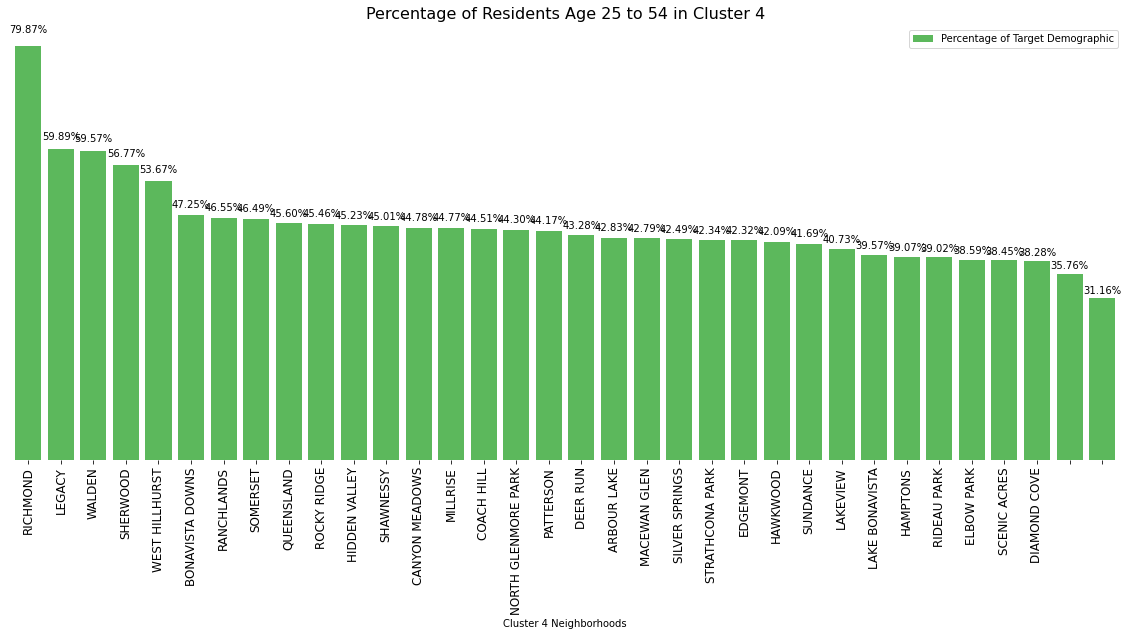

In [92]:
colors_list = ['#5cb85c']

#Plot Bar chart with required specifications
ax4 = result4.plot(kind='bar', use_index=True, figsize=(20,8),width = 0.8,color = colors_list,edgecolor=None)
ax4.set_xticklabels(result3['NAME'])
ax4.set_xlabel('Cluster 4 Neighborhoods')
plt.title("Percentage of Residents Age 25 to 54 in Cluster 4",fontsize= 16)

#Remove the left, Top and Right borders of the bars
plt.xticks(fontsize=12)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the % annotations above the bars
for p in ax4.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax4.annotate(f'{height:.2%}', (x + width/2, y + height*1.03), ha='center')

In [93]:
#Graph the income data for Cluster 3
inc_c4 = clus4g1.drop(['RES_CNT','Percentage of Target Demographic'], axis=1)
inc_c4.sort_values(['Average Household Income After Taxes'],ascending=False, axis=0, inplace=True)

# Filter for ideal neighborhood in cluster based on avobe criteria
# Filter for Target Demographic
index_inc1_c4 = inc_c4[ inc_c4['Number of Residents Age 25 to 54'] < 2609 ].index
# Delete these row indexes from dataFrame
inc_c4.drop(index_inc1_c4 , inplace=True)

#Filter for Average Household Income
index_inc2_c4 = inc_c4[ inc_c4['Average Household Income After Taxes'] < 87573.71 ].index
# Delete these row indexes from dataFrame
inc_c4.drop(index_inc2_c4 , inplace=True)

#Filter for Median Household Income
index_inc3_c4 = inc_c4[ inc_c4['Median Household Income After Taxes'] < 69628.53 ].index
# Delete these row indexes from dataFrame
inc_c4.drop(index_inc3_c4 , inplace=True)

inc_c4.set_index(['NAME'])

Number of Residents Age 25 to 54  \
NAME                                                 
CRESCENT HEIGHTS                              3965   
RENFREW                                       3921   

                  Average Household Income After Taxes  \
NAME                                                     
CRESCENT HEIGHTS                              103136.0   
RENFREW                                       103136.0   

                  Median Household Income After Taxes  
NAME                                                   
CRESCENT HEIGHTS                              72113.0  
RENFREW                                       72113.0

Text(0.5, 1.0, 'Top 2 Potential Neighborhoods in Cluster 4')

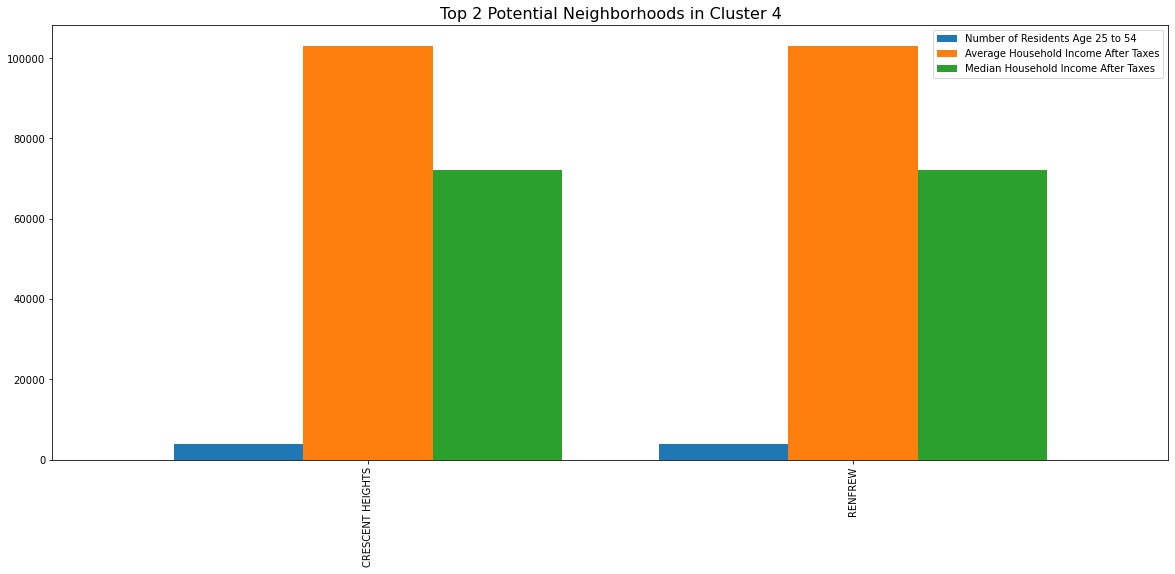

In [94]:
ax4_inc = inc_c4.plot.bar(rot=0,figsize=(20,8),width = 0.8)
ax4_inc.set_xticklabels(inc_c4['NAME'])
plt.xticks(rotation=90)
plt.title("Top 2 Potential Neighborhoods in Cluster 4",fontsize= 16)